Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Number of event classes: 18
Found 500 matches
Training matches: 350
Validation matches: 75
Test matches: 75
Creating training dataset...


Indexing train matches:   0%|          | 0/50 [00:00<?, ?it/s]

Creating validation dataset...


Indexing val matches:   0%|          | 0/10 [00:00<?, ?it/s]

Creating test dataset...


Indexing test matches:   0%|          | 0/10 [00:00<?, ?it/s]

EventDetectionModel(
  (lstm): LSTM(2048, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=18, bias=True)
)


Epoch 1/3 - Training:   0%|          | 0/3422 [00:00<?, ?it/s]

Epoch 1/3 - Validation:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.0701, Val Loss: 0.0660, Val Acc: 0.9921


Epoch 2/3 - Training:   0%|          | 0/3422 [00:00<?, ?it/s]

Epoch 2/3 - Validation:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.0663, Val Loss: 0.0620, Val Acc: 0.9921


Epoch 3/3 - Training:   0%|          | 0/3422 [00:00<?, ?it/s]

Epoch 3/3 - Validation:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.0646, Val Loss: 0.1054, Val Acc: 0.9921


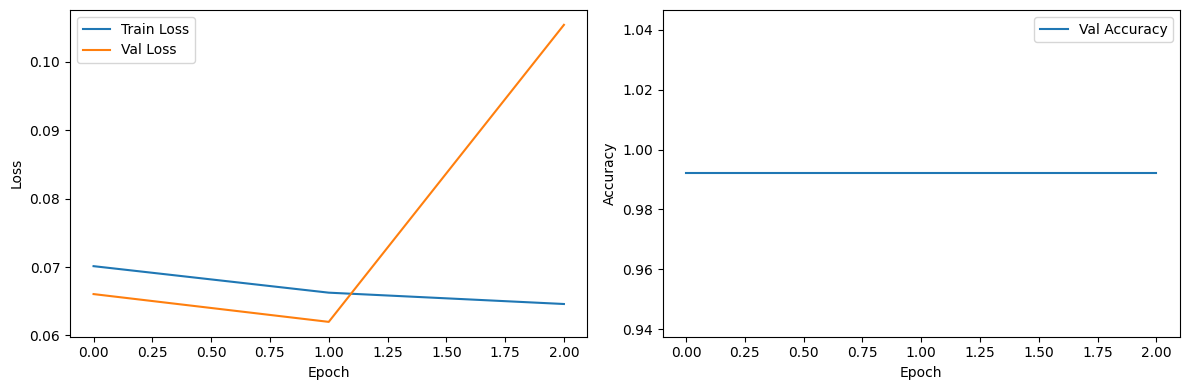

Evaluating:   0%|          | 0/683 [00:00<?, ?it/s]

ValueError: Number of classes, 13, does not match size of target_names, 18. Try specifying the labels parameter

In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm.notebook import tqdm
from google.colab import drive
import gc

# Mount Google Drive
drive.mount('/content/drive')

# Path to your SoccerNet dataset shortcut
SOCCERNET_PATH = "/content/drive/MyDrive/soccernet"

# Define constants
FPS = 2  # ResNet features are extracted at 2 frames per second
WINDOW_SIZE = 20  # 10-second window (10s * 2fps = 20 frames)
STEP_SIZE = 5    # Step size for sliding window (2.5s)

class EventMapper:
    """Maps event labels to numerical indices and vice versa"""

    def __init__(self):
        # List of event labels in SoccerNet-v2
        self.events = [
            "Ball out of play", "Throw-in", "Foul", "Indirect free-kick",
            "Clearance", "Shot", "Shot on target", "Goal", "Corner", "Substitution",
            "Kick-off", "Yellow card", "Offside", "Direct free-kick", "Red card",
            "Yellow->red card", "Penalty"
        ]
        # Add "Background" class for frames without events
        self.events.append("Background")

        # Create mappings
        self.event_to_idx = {event: i for i, event in enumerate(self.events)}
        self.idx_to_event = {i: event for i, event in enumerate(self.events)}

    def get_num_classes(self):
        return len(self.events)

    def event_to_index(self, event):
        return self.event_to_idx.get(event, self.event_to_idx["Background"])

    def index_to_event(self, idx):
        return self.idx_to_event[idx]

def game_time_to_frame(game_time, fps=FPS):
    """Convert game time string (e.g. '1 - 00:00') to frame number"""
    half, time_str = game_time.split(" - ")
    minutes, seconds = time_str.split(":")

    # Convert to seconds
    total_seconds = int(half) * 45 * 60 + int(minutes) * 60 + int(seconds)

    # Convert to frame number
    frame_number = total_seconds * fps

    return frame_number

def load_labels(json_path):
    """Load labels from SoccerNet json file and convert to frame-level annotations"""
    with open(json_path, 'r') as f:
        data = json.load(f)

    annotations = data.get('annotations', [])
    frame_labels = []

    for annotation in annotations:
        game_time = annotation['gameTime']
        label = annotation['label']
        position = int(annotation['position'])  # Frame position in the video
        team = annotation['team']
        visibility = annotation['visibility']

        # Calculate the frame number from game time
        frame_number = game_time_to_frame(game_time)

        # Only include visible events
        if visibility == "visible":
            frame_labels.append({
                'frame': frame_number,
                'label': label,
                'position': position,
                'team': team
            })

    return frame_labels

def get_match_paths():
    """Return all match paths from the SoccerNet dataset"""
    match_paths = []

    # List of leagues
    leagues = ['england_epl', 'europe_uefa-champions-league', 'france_ligue-1',
               'germany_bundesliga', 'italy_serie-a', 'spain_laliga']

    # List of seasons
    seasons = ['2014-2015', '2015-2016', '2016-2017']

    # Traverse through all leagues and seasons
    for league in leagues:
        league_path = os.path.join(SOCCERNET_PATH, league)
        if not os.path.exists(league_path):
            print(f"Warning: League path {league_path} does not exist")
            continue

        for season in seasons:
            season_path = os.path.join(league_path, season)
            if not os.path.exists(season_path):
                print(f"Warning: Season path {season_path} does not exist")
                continue

            # Get all match directories
            for match_dir in os.listdir(season_path):
                match_path = os.path.join(season_path, match_dir)
                if os.path.isdir(match_path):
                    # Check if the required files exist
                    labels_path = os.path.join(match_path, 'Labels-v2.json')
                    half1_path = os.path.join(match_path, '1_ResNET_TF2.npy')
                    half2_path = os.path.join(match_path, '2_ResNET_TF2.npy')

                    if os.path.exists(labels_path) and os.path.exists(half1_path) and os.path.exists(half2_path):
                        match_paths.append(match_path)

    return match_paths

class SoccerNetDataset(Dataset):
    """Memory-efficient SoccerNet Dataset"""

    def __init__(self, match_paths, event_mapper, max_matches=None, mode='train'):
        self.match_paths = match_paths[:max_matches] if max_matches else match_paths
        self.event_mapper = event_mapper
        self.mode = mode
        self.samples = []

        # Pre-compute the indices (but don't load features yet)
        self._precompute_indices()

    def _precompute_indices(self):
        """Precompute all sample indices without loading features"""
        for match_idx, match_path in enumerate(tqdm(self.match_paths, desc=f"Indexing {self.mode} matches")):
            try:
                # Load label data
                labels_path = os.path.join(match_path, 'Labels-v2.json')
                frame_labels = load_labels(labels_path)

                # Process each half
                for half_idx in [1, 2]:
                    # Get the expected number of frames without loading features
                    half_file = os.path.join(match_path, f'{half_idx}_ResNET_TF2.npy')
                    if not os.path.exists(half_file):
                        continue

                    # Get shape without loading full array
                    with open(half_file, 'rb') as f:
                        version = np.lib.format.read_magic(f)
                        shape, _, _ = np.lib.format.read_array_header_1_0(f)
                        num_frames = shape[0]

                    # Create sliding window indices
                    for i in range(0, num_frames - WINDOW_SIZE + 1, STEP_SIZE):
                        middle_frame = i + WINDOW_SIZE // 2
                        self.samples.append((match_path, half_idx, i, middle_frame))
            except Exception as e:
                print(f"Error processing {match_path}: {str(e)}")
                continue

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        match_path, half_idx, window_start, middle_frame = self.samples[idx]

        try:
            # Load only the needed half features
            half_file = os.path.join(match_path, f'{half_idx}_ResNET_TF2.npy')
            features = np.load(half_file, mmap_mode='r')  # Memory-mapped

            # Get the window features
            window_features = features[window_start:window_start+WINDOW_SIZE]

            # Load labels if they exist
            label = self.event_mapper.event_to_index("Background")
            labels_path = os.path.join(match_path, 'Labels-v2.json')

            if os.path.exists(labels_path):
                frame_labels = load_labels(labels_path)
                for event in frame_labels:
                    frame = event['frame']
                    # Check if this event belongs to the current half
                    if (half_idx == 1 and frame < 45 * 60 * FPS) or (half_idx == 2 and frame >= 45 * 60 * FPS):
                        # Adjust frame number for second half
                        if half_idx == 2:
                            frame = frame - 45 * 60 * FPS

                        if frame == middle_frame:
                            label = self.event_mapper.event_to_index(event['label'])
                            break

            return torch.tensor(window_features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading sample {idx}: {str(e)}")
            # Return a dummy sample (you might want to handle this differently)
            dummy_features = torch.zeros((WINDOW_SIZE, 2048), dtype=torch.float32)
            dummy_label = torch.tensor(self.event_mapper.event_to_index("Background"), dtype=torch.long)
            return dummy_features, dummy_label

class EventDetectionModel(nn.Module):
    """Neural network for soccer event detection"""

    def __init__(self, input_dim, hidden_dims, num_classes):
        super(EventDetectionModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dims[0],
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.5
        )

        # FC layers
        fc_layers = []

        # Input dim for first FC is 2 * hidden_dim (due to bidirectional LSTM)
        prev_dim = hidden_dims[0] * 2

        for hidden_dim in hidden_dims[1:]:
            fc_layers.append(nn.Linear(prev_dim, hidden_dim))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(0.5))
            prev_dim = hidden_dim

        self.fc_layers = nn.Sequential(*fc_layers)
        self.output_layer = nn.Linear(prev_dim, num_classes)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Use the output from the last time step
        last_output = lstm_out[:, -1, :]

        # FC layers
        x = self.fc_layers(last_output)

        # Output layer
        logits = self.output_layer(x)

        return logits

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    """Train the model"""
    # Move model to device
    model.to(device)

    # Training history
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Best validation accuracy
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            features = features.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for features, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(features)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * features.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Acc: {epoch_val_acc:.4f}")

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()

    # Load the best model
    model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, val_accuracies

def evaluate_model(model, test_loader, event_mapper, device='cuda'):
    """Evaluate the trained model"""
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc="Evaluating"):
            features = features.to(device)
            outputs = model(features)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calculate metrics
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=[event_mapper.index_to_event(i) for i in range(event_mapper.get_num_classes())],
        zero_division=0
    )

    print(report)

    # Create confusion matrix
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[event_mapper.index_to_event(i) for i in range(event_mapper.get_num_classes())],
        yticklabels=[event_mapper.index_to_event(i) for i in range(event_mapper.get_num_classes())]
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return report, cm

def predict_events(model, match_path, event_mapper, device='cuda'):
    """Predict events for a given match"""
    model.eval()

    # Load ResNet features
    half1_features = np.load(os.path.join(match_path, '1_ResNET_TF2.npy'))
    half2_features = np.load(os.path.join(match_path, '2_ResNET_TF2.npy'))

    predictions = []

    for half_idx, features in enumerate([half1_features, half2_features], 1):
        num_frames = len(features)
        half_predictions = np.full(num_frames, event_mapper.event_to_index("Background"))

        # Create sliding windows
        for i in range(0, num_frames - WINDOW_SIZE + 1, STEP_SIZE):
            window_features = features[i:i+WINDOW_SIZE]

            # Convert to tensor
            window_tensor = torch.tensor(window_features, dtype=torch.float32).unsqueeze(0).to(device)

            # Make prediction
            with torch.no_grad():
                output = model(window_tensor)
                _, prediction = torch.max(output, 1)

            # Assign prediction to the middle frame
            middle_frame = i + WINDOW_SIZE // 2
            half_predictions[middle_frame] = prediction.item()

        # Convert predictions to event names
        half_events = []
        for i, pred in enumerate(half_predictions):
            if pred != event_mapper.event_to_index("Background"):
                event_name = event_mapper.index_to_event(pred)
                # Calculate game time
                seconds = i / FPS
                minutes = int(seconds // 60)
                seconds = int(seconds % 60)
                game_time = f"{half_idx} - {minutes:02d}:{seconds:02d}"

                half_events.append({
                    'game_time': game_time,
                    'label': event_name,
                    'frame': i,
                    'half': half_idx
                })

        predictions.extend(half_events)

    return predictions

def main():
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create event mapper
    event_mapper = EventMapper()
    print(f"Number of event classes: {event_mapper.get_num_classes()}")

    # Get all match paths
    match_paths = get_match_paths()
    print(f"Found {len(match_paths)} matches")

    # Split matches into train, validation, and test sets
    train_matches, temp_matches = train_test_split(match_paths, test_size=0.3, random_state=42)
    val_matches, test_matches = train_test_split(temp_matches, test_size=0.5, random_state=42)

    print(f"Training matches: {len(train_matches)}")
    print(f"Validation matches: {len(val_matches)}")
    print(f"Test matches: {len(test_matches)}")

    # Create datasets - now much more memory efficient
    print("Creating training dataset...")
    train_dataset = SoccerNetDataset(train_matches, event_mapper, max_matches=50, mode='train')

    print("Creating validation dataset...")
    val_dataset = SoccerNetDataset(val_matches, event_mapper, max_matches=10, mode='val')

    print("Creating test dataset...")
    test_dataset = SoccerNetDataset(test_matches, event_mapper, max_matches=10, mode='test')

    # Create data loaders with smaller batch sizes
    batch_size = 32  # Reduced from 64 to save memory
    num_workers = 2

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True  # Helps with GPU transfer
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    # Create model
    input_dim = 2048  # Assuming ResNet features are 2048-dimensional
    hidden_dims = [256, 128]
    num_classes = event_mapper.get_num_classes()

    model = EventDetectionModel(input_dim, hidden_dims, num_classes)
    print(model)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Train model with periodic garbage collection
    num_epochs = 3
    model, train_losses, val_losses, val_accuracies = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=num_epochs,
        device=device
    )

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate model
    report, cm = evaluate_model(model, test_loader, event_mapper, device=device)

    # Save model
    torch.save(model.state_dict(), '/content/drive/MyDrive/soccernet_event_detection_model.pth')

    # Example: Predict events for a test match
    if len(test_matches) > 0:
        test_match = test_matches[0]
        print(f"Predicting events for match: {os.path.basename(test_match)}")

        predictions = predict_events(model, test_match, event_mapper, device=device)

        # Display predictions
        print("Predicted events:")
        for pred in predictions:
            print(f"{pred['game_time']}: {pred['label']}")

    print("Done!")

if __name__ == "__main__":
    main()